In [1]:
%load_ext autoreload
%autoreload 2

The purpose of this notebook is to compute information gains as efficiently as possible.

First, we need to establish some ground truth information gains:

In [36]:
from hyperdt.tree import HyperbolicDecisionTreeClassifier
import embedders
import torch
import numpy as np
import matplotlib.pyplot as plt


In [37]:
pm = embedders.manifolds.ProductManifold(signature=[(-1, 4)])

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm)
print(X.shape, y.shape)

torch.Size([1000, 5]) torch.Size([1000])


/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


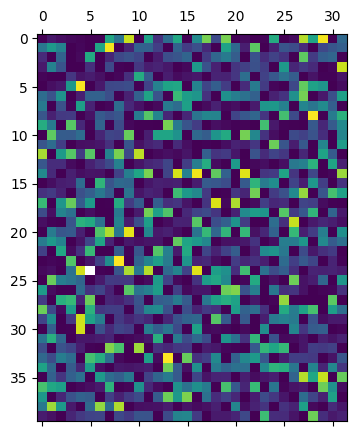

In [47]:
# Compute information gains for every possible split

hdt = HyperbolicDecisionTreeClassifier()
hdt.classes_ = [0, 1]

info_gains = torch.zeros_like(X, dtype=torch.float64)
for i in range(X.shape[0]):
    for j in range(1, X.shape[1]):
        theta = np.arctan2(X[i, 0].item(), X[i, j].item())
        left, right = hdt._get_split(X=X.detach().numpy(), dim=j, theta=theta)
        score = hdt._information_gain(left, right, y.detach().numpy())
        info_gains[i, j] = score

plt.matshow(info_gains[:32*8, :].reshape(-1, 32))

In [52]:
# Great, now we have ground truth. Can we do it with tensors?

info_gains_torch = torch.zeros_like(X)

# First, we process our X-values into coordinates:
# (batch, dims + 1) --> (batch, dims)
angles = torch.arctan2(X[:,0:1], X[:, 1:])

# Now, we create a tensor of comparisons
# (batch, dims, batch)
comparisons = angles[None, :] > angles[:, None]
print(comparisons.shape)

torch.Size([1000, 1000, 4])


In [56]:
print((angles[:, None] > angles[None, :]).shape)

torch.Size([1000, 1000, 4])
